<a href="https://colab.research.google.com/github/FatimaALzahrani/E-Commerce-Event-Prediction-with-Markov-Chains/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **E-Commerce Event Prediction with Markov Chains**

In this notebook, we explore e-commerce event prediction using Markov Chains, focusing on user interactions with products. We will clean, analyze, visualize the data, and then build a prediction model based on transition matrices. The dataset includes various user activities (views, cart additions, purchases) associated with different products.

## **Import Libraries 📚**

Here, I import essential Python libraries for data manipulation, visualization, and machine learning:

In [1]:
import pandas as pd
import numpy as np
import os
from google.colab import drive
import random as rm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

## **Load and Clean Data 🧹**

In this section, we load the dataset and clean it by:

1. Removing rows with missing critical information (such as 'event_type', 'user_id', 'product_id', 'price').
2. Filling missing values for 'category_code' and 'brand' with 'Unknown'.
3. Filtering out rows where 'price' is zero or negative.
4. Mapping event types to more understandable categories ('view' → 'Viewing', 'cart' → 'Adding to Cart', 'purchase' → 'Purchasing').

In [2]:
def load_and_clean_data(file_path):
    data = pd.read_csv(file_path)

    critical_columns = ['event_type', 'user_id', 'product_id', 'price']
    data.dropna(subset=critical_columns, inplace=True)

    data['category_code'].fillna('Unknown', inplace=True)
    data['brand'].fillna('Unknown', inplace=True)

    data = data[data['price'] > 0]

    event_state_map = {
        'view': 'Viewing',
        'cart': 'Adding to Cart',
        'purchase': 'Purchasing'
    }
    data['state'] = data['event_type'].map(event_state_map)

    data = data[data['state'].notnull()]

    print("Data cleaning completed.")
    return data

In [3]:
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/data_eco.csv'
data = load_and_clean_data(file_path)

Mounted at /content/drive


<ipython-input-2-ebe3554a1243>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['category_code'].fillna('Unknown', inplace=True)
<ipython-input-2-ebe3554a1243>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

Data cleaning completed.


In [4]:
total_rows = len(data)
unique_users = data['user_id'].nunique()

print(f"Total rows: {total_rows}")
print(f"Unique users: {unique_users}")

Total rows: 1008491
Unique users: 171503


## **Dataset Description and Statistics 📑**

This section provides a summary of the dataset's statistics, including the distribution of numerical and categorical variables. It helps understand the dataset's structure before performing further analysis.


In [5]:
def describe_dataset(data):
    stats = data.describe(include='all')
    print(stats)
    return stats

stats = describe_dataset(data)

                     event_time event_type    product_id   category_id  \
count                   1008491    1008491  1.008491e+06  1.008491e+06   
unique                    55194          3           NaN           NaN   
top     2019-11-01 14:18:02 UTC       view           NaN           NaN   
freq                         96     975508           NaN           NaN   
mean                        NaN        NaN  1.059999e+07  2.057542e+18   
std                         NaN        NaN  1.199691e+07  1.890861e+16   
min                         NaN        NaN  1.000978e+06  2.053014e+18   
25%                         NaN        NaN  1.005186e+06  2.053014e+18   
50%                         NaN        NaN  4.900088e+06  2.053014e+18   
75%                         NaN        NaN  1.570018e+07  2.053014e+18   
max                         NaN        NaN  6.060000e+07  2.180737e+18   

       category_code    brand         price       user_id  \
count        1008491  1008491  1.008491e+06  1.008

## **Visualize data 📊**

### **Price distribution**

Visualize the distribution of product prices using a histogram to understand the spread of prices in the dataset.

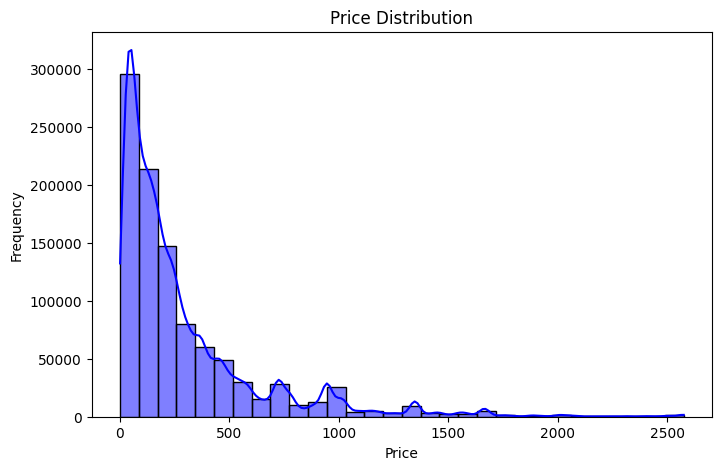

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(data['price'], bins=30, kde=True, color='blue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

### **Event type counts**

<ipython-input-7-07e6bbce2727>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='state', order=data['state'].value_counts().index, palette="Set2")


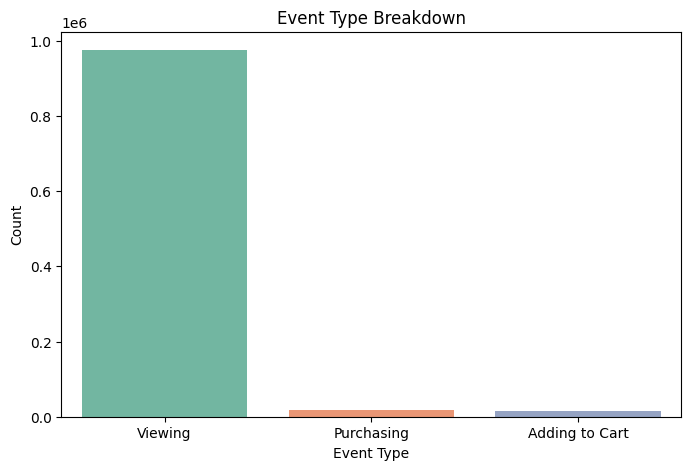

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='state', order=data['state'].value_counts().index, palette="Set2")
plt.title('Event Type Breakdown')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

Create a heatmap to explore the relationship between product categories and event types. This helps visualize where users are most engaged (viewing, adding to cart, purchasing).

### Heatmap: Event type vs. Product categories

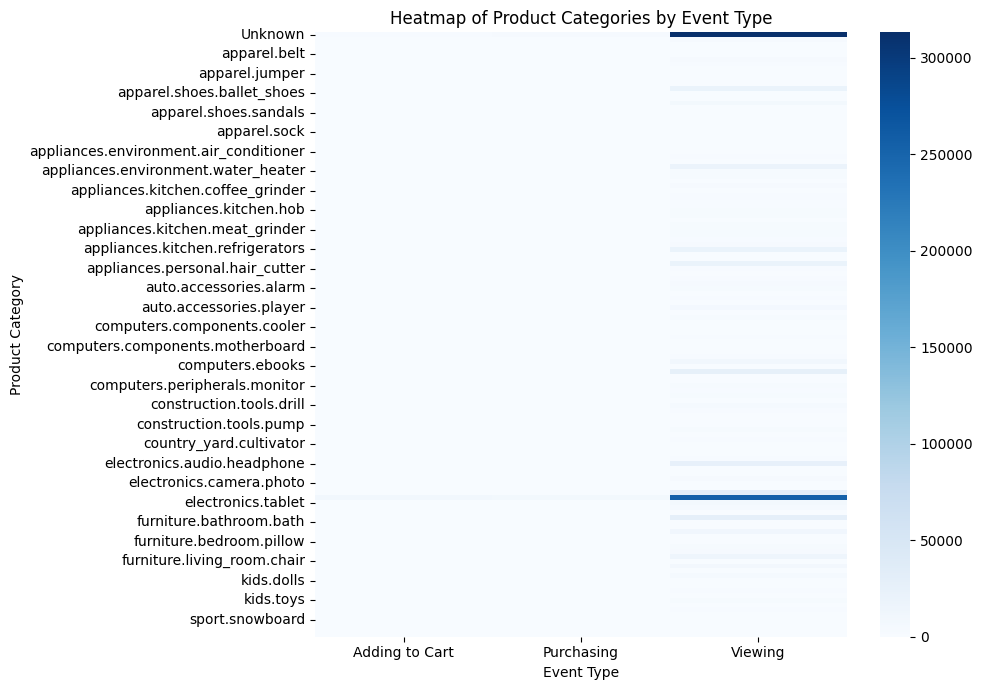

In [8]:
plt.figure(figsize=(10, 7))
category_event_counts = pd.crosstab(data['category_code'], data['state'])
sns.heatmap(category_event_counts, cmap="Blues", annot=False)
plt.title('Heatmap of Product Categories by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()

## **Calculate Transition Matrix 🔢**

In this section, we calculate the transition matrix, which is used in the Markov Chain model. The transition matrix represents the probabilities of moving from one event type to another.

In [9]:
def calculate_transition_matrix(data):
    states = data['state'].unique()
    transition_counts = pd.crosstab(data['state'], data['state'].shift(-1), normalize='index')
    transition_matrix = transition_counts.fillna(0).values
    if not np.allclose(transition_matrix.sum(axis=1), 1):
        raise ValueError("Probabilities MUST ADD TO 1")
    return transition_matrix, states

    transition_matrix, states = calculate_transition_matrix(data)

In [10]:
transition_matrix, states = calculate_transition_matrix(data)

In [11]:
print("Transition Matrix:")
print(transition_matrix)

Transition Matrix:
[[0.01765682 0.0189844  0.96335878]
 [0.01439893 0.01791495 0.96768613]
 [0.01490609 0.01774564 0.96734826]]


## **Visualize transition matrix 📊**

Now, visualize the transition matrix as a heatmap, which provides a clear representation of the probabilities of transitions between different event types.

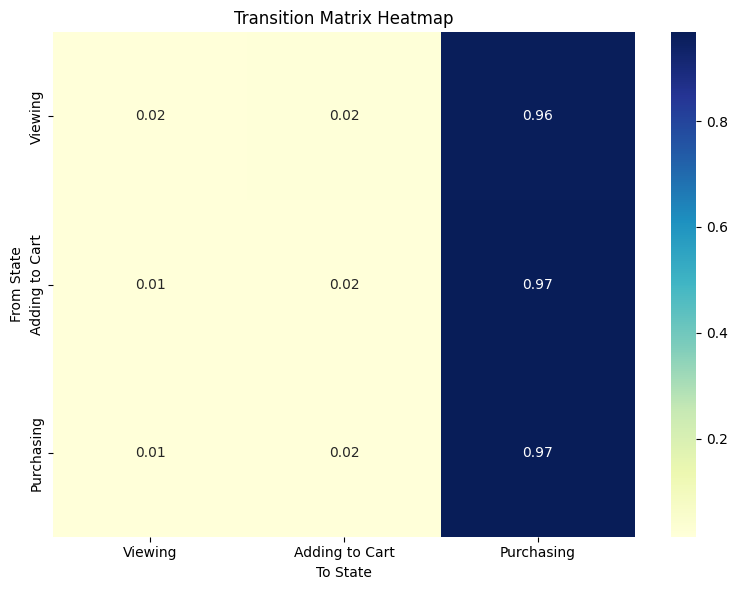

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, cmap="YlGnBu", xticklabels=states, yticklabels=states, fmt=".2f")
plt.title("Transition Matrix Heatmap")
plt.xlabel("To State")
plt.ylabel("From State")
plt.tight_layout()
plt.show()

## **Markov chain prediction 🤖**

Use the transition matrix to predict the next states over a period of days. This simulates user behavior based on their previous interactions.

In [13]:
def markov_chain_prediction(matrix, states, start_state, days=10):
    current_state = start_state
    predictions = [current_state]
    for _ in range(1, days):
        next_state = np.random.choice(states, replace=True, p=matrix[states.tolist().index(current_state)])
        predictions.append(next_state)
        current_state = next_state
    return predictions

## **Simulate Predictions for 30 Days 📅**

Simulate the predicted sequence of event types for the next 30 days, and compare them with the true sequence.

In [14]:
days_to_simulate = 30
start_state = "Viewing"
predicted_states = markov_chain_prediction(transition_matrix, states, start_state, days=days_to_simulate)
true_states = markov_chain_prediction(transition_matrix, states, start_state, days=days_to_simulate)

print("Predicted States:", predicted_states)
print("True States:", true_states)

Predicted States: ['Viewing', 'Purchasing', 'Purchasing', 'Adding to Cart', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Adding to Cart', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing']
True States: ['Viewing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Adding to Cart', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing', 'Purchasing']


### **Calculate prediction accuracy**

Compare the predicted states with the true states to calculate the prediction accuracy.

In [15]:
accuracy = sum(1 for a, p in zip(true_states, predicted_states) if a == p) / len(true_states)
print(f"Prediction Accuracy: {accuracy * 100:.2f}%")

Prediction Accuracy: 90.00%


## **Evaluate Model Performance 🧮**

Generate the classification report and confusion matrix to evaluate the performance of the prediction model.



In [16]:
print(classification_report(true_states, predicted_states, zero_division=0))

                precision    recall  f1-score   support

Adding to Cart       0.00      0.00      0.00         1
    Purchasing       0.96      0.93      0.95        28
       Viewing       1.00      1.00      1.00         1

      accuracy                           0.90        30
     macro avg       0.65      0.64      0.65        30
  weighted avg       0.93      0.90      0.92        30



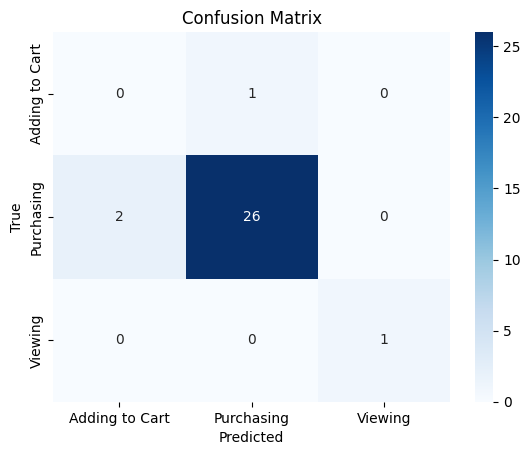

In [17]:
cm = confusion_matrix(true_states, predicted_states, labels=np.unique(true_states))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(true_states), yticklabels=np.unique(true_states))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [18]:
accuracy = accuracy_score(true_states, predicted_states)
precision = precision_score(true_states, predicted_states, average='weighted', zero_division=0)
recall = recall_score(true_states, predicted_states, average='weighted', zero_division=0)
error_rate = 1 - accuracy
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"Error Rate: {error_rate:.2%}")

Accuracy: 90.00%
Precision: 93.21%
Recall: 90.00%
Error Rate: 10.00%


## **Visualize State Distributions 📉**

Plot the distribution of true and predicted states to visualize the model’s performance.

### True states distribution

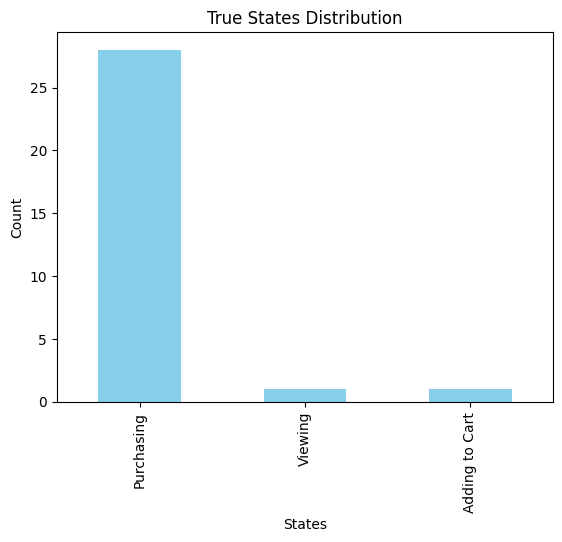

In [19]:
true_state_counts = pd.Series(true_states).value_counts()
true_state_counts.plot(kind='bar', title='True States Distribution', color='skyblue')
plt.xlabel('States')
plt.ylabel('Count')
plt.show()

### Predicted states distribution

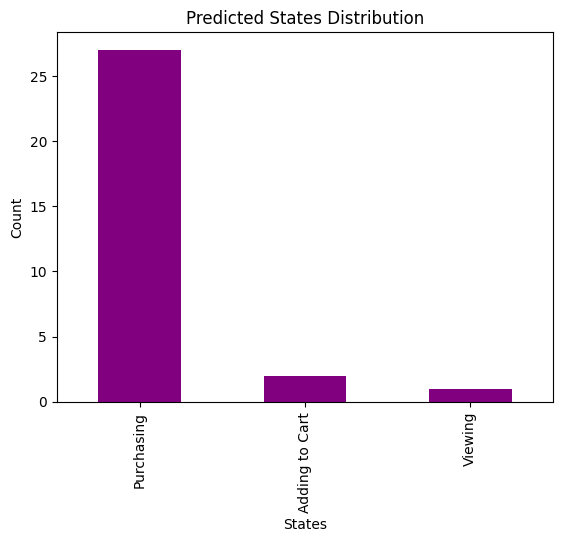

In [20]:
predicted_state_counts = pd.Series(predicted_states).value_counts()
predicted_state_counts.plot(kind='bar', title='Predicted States Distribution', color='purple')
plt.xlabel('States')
plt.ylabel('Count')
plt.show()

## **Save Predictions and Results 📝**

Save the transition matrix, predictions, and cleaned dataset to CSV files for further analysis or reporting.


In [21]:
output_path = '/content/drive/MyDrive/'
pd.DataFrame(transition_matrix, index=states, columns=states).to_csv(os.path.join(output_path, 'transition_matrix.csv'))
pd.DataFrame({'True States': true_states, 'Predicted States': predicted_states}).to_csv(os.path.join(output_path, 'predictions.csv'))
data.to_csv(os.path.join(output_path, 'cleaned_dataset.csv'), index=False)

print("Results and files saved.")

Results and files saved.
